<a href="https://colab.research.google.com/github/southjohn64/exercises/blob/main/dl_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import random
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm


def initialize_parameters(layer_dims):
    '''
    :param is_test_mode: in test mode all W will be ones vector
    :param layer_dims:  an array of the dimensions of each layer in the network
    (layer 0 is the size of the flattened input, layer L is the output softmax)
    :return: a dictionary containing the initialized W and b parameters of each layer (W1…WL, b1…bL)
    '''
    w_b_parmas_dic = {}
    for i in range(1, len(layer_dims)):
        layer_dim_prev = layer_dims[i - 1]
        layer_dim = layer_dims[i]
        w_b_parmas_dic['W' + str(i)] = np.random.randn(layer_dim, layer_dim_prev) * (np.sqrt(2. / layer_dim_prev))
        w_b_parmas_dic['b' + str(i)] = np.zeros((layer_dim, 1))

    return w_b_parmas_dic


def linear_forward(A, W, b):
    '''
        Implement the linear part of a layer's forward propagation
        :param A: the activations of the previous layer
        :param W: the weight matrix of the current layer (of shape [size of current layer, size of previous layer])
        :param b: the bias vector of the current layer (of shape [size of current layer, 1])
        :return: Z – the linear component of the activation function (i.e., the value before applying the non-linear function)
        linear_cache – a dictionary containing A, W, b (stored for making the backpropagation easier to compute)
    '''

    # A is in fact the original X features after activations, so layer 1 get the original X vector (as there is no
    # activation yet)
    Z = np.dot(W, A) + b
    linear_cache = {'A': A, 'W': W, 'b': b, 'Z': Z}  # i added the Z for the backprop
    return Z, linear_cache

def softmax(z):
    shiftz = z - np.max(z)
    a = np.divide(np.exp(shiftz), np.sum(np.exp(shiftz), axis=0))

    activation_cache = {'Z': z, 'A': a}  # i added the A for the backprop

    return a, activation_cache


def relu(Z):
    '''

    :param Z:the linear component of the activation function
    :return: A – the activations of the layer
    activation_cache – returns Z, which will be useful for the backpropagation

    '''

    A = np.maximum(0, Z)
    activation_cache = {'Z': Z, 'A': A}  # i added the A for the backprop

    return A, activation_cache


def linear_activation_forward(A_prev, W, B, activation):
    cache = {}
    Z_current, linear_cache = linear_forward(A_prev, W, B)

    if activation == 'softmax':
        A_current, activation_cache = softmax(Z_current)
    elif activation == 'relu':
        A_current, activation_cache = relu(Z_current)
    cache['linear'] = linear_cache
    cache['activation'] = activation_cache
    return A_current, cache


def L_model_forward(X, parameters, use_batchnorm):
    '''
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX computation
    :param X:the data, numpy array of shape (input size, number of examples)
    :param parameters: the initialized W and b parameters of each layer
    :param use_batchnorm:
    :return: AL - the last post-activation value
    caches – a list of all the cache objects generated by the linear_forward function
    '''
    caches = []
    net_size = len(parameters) // 2  # since the dic has w and b for each layer
    A_current = X
    for i in range(1, net_size):  # running on all hidden layers except the last layer

        W = parameters['W' + str(i)]
        b = parameters['b' + str(i)]
        A_current, cache = linear_activation_forward(A_current, W, b, 'relu')
        caches.append(cache)
        if use_batchnorm:
            A_current = apply_batchnorm(A_current)

    # running the last layer with the softmax
    W = parameters['W' + str(net_size)]
    b = parameters['b' + str(net_size)]
    A_L, cache = linear_activation_forward(A_current, W, b, 'softmax')
    caches.append(cache)
    return A_L, caches



def apply_batchnorm(A):
    epsilon = 1e-5
    mu = np.mean(A, axis=0)
    var = np.var(A, axis=0)

    return (A - mu) / np.sqrt(var + epsilon)


def compute_cost(AL, Y):
    loss = np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    cost = -(1. / Y.shape[1]) * loss
    return cost


# region backward propagation functions

def L_model_backward(AL, Y, caches):
    grads = {}

    num_layers = len(caches)
    cache_softmax_last_layer = caches[num_layers - 1]
    dA_prev = AL - Y
    dA_prev, dW, db = linear_activation_backward(dA_prev, cache_softmax_last_layer, 'softmax')
    grads["dW" + str(num_layers)] = dW
    grads["db" + str(num_layers)] = db

    for i in range(num_layers - 1, 0, -1):  # run from the last relu layer to 0
        cache_layer = caches[i - 1]
        dA_prev, dW, db = linear_activation_backward(dA_prev, cache_layer, 'relu')

        grads["dW" + str(i)] = dW
        grads["db" + str(i)] = db

    return grads


def Linear_backward(dZ, cache):
    '''
    Implements the linear part of the backward propagation process for a single layer
    :param dZ: the gradient of the cost with respect to the linear output of the current layer (layer l)
    :param cache: tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    :return:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    '''

    A_prev, W, b = cache
    m = dZ.shape[0]
    dA_prev = np.dot(W.T, dZ)
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    activation_cache = cache['activation']
    linear_cache_tuple = (cache['linear']['A'], cache['linear']['W'], cache['linear']['b'])

    if activation == 'softmax':
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = Linear_backward(dZ, linear_cache_tuple)
    elif activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = Linear_backward(dZ, linear_cache_tuple)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache['Z']
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    dZ[Z > 0] = 1
    return dA * dZ


def softmax_backward(dA, activation_cache):
    '''
    Pi-Yi
    :param dA: Y true label vector
    :param activation_cache:
    :return:
    '''
    AL = activation_cache['A']  # A of the last layer is the AL softmax vector
    dZ = dA
    return dZ


# endregion

def Update_parameters(parameters: dict, grads: dict, learning_rate):
    for param_key, value in parameters.items():
        parameters[param_key] = parameters[param_key] - learning_rate * grads["d" + param_key]
    return parameters


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def split_train_val(X, Y, ratio=0.2):
    X, Y = unison_shuffled_copies(X.T, Y.T)
    # by col
    num_samples = X.shape[0]
    num_train_samples = int(num_samples * (1.0 - ratio))

    X_train = X[:num_train_samples]  # [0, num_train_samples-1]
    Y_train = Y[:num_train_samples]

    X_val = X[num_train_samples:]
    Y_val = Y[num_train_samples:]

    X_train = X_train.T
    Y_train = Y_train.T
    X_val = X_val.T
    Y_val = Y_val.T

    return X_train, Y_train, X_val, Y_val


def split_to_batch(X_train, Y_train, batch_size):
    X_batches = []
    Y_batches = []
    num_of_samples = X_train.shape[1]

    num_of_batchs = int(np.ceil(float(num_of_samples) / batch_size))
    X_batches = np.hsplit(X_train, num_of_batchs)
    Y_batches = np.hsplit(Y_train, num_of_batchs)

    return X_batches, Y_batches


def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm):
    val_costs = []
    val_acc = []

    w_b_parmas_dic = initialize_parameters(layers_dims)
    stopping_criteria = 1e-3  # when the accuracy diff between iteration is less then 5% we stop

    X = X.T
    Y = Y.T
    X_train, Y_train, X_val, Y_val = split_train_val(X, Y)
    X_batches, Y_batches = split_to_batch(X_train, Y_train, batch_size)

    iter_num = 1
    reached_stopping_criteria = False
    while not reached_stopping_criteria and iter_num <= num_iterations:
        batch_idx = iter_num % len(X_batches)
        X_batch, Y_batch = X_batches[batch_idx - 1], Y_batches[batch_idx - 1]

        # training
        A_L, caches = L_model_forward(X_batch, parameters=w_b_parmas_dic, use_batchnorm=use_batchnorm)


        if iter_num % 100 == 0:
            # validation
            val_AL, _ = L_model_forward(X_val, parameters=w_b_parmas_dic, use_batchnorm=use_batchnorm)
            val_cost = compute_cost(val_AL, Y_val)
            val_costs.append(val_cost)

            val_accuracy = Predict(X_val, Y_val, w_b_parmas_dic,use_batchnorm)

            print("# iter {} , val acc {} , val cost {}".format(str(iter_num), str(val_accuracy), str(val_cost)))

          # stopping criteria every 100 iter

            if len(val_costs) > 2 and abs(val_costs[-1] - val_costs[-2]) < stopping_criteria :
              print("reached stopping criteria in iteration: {} , val cost : {}".format(str(iter_num), str(val_costs[-1])))
              reached_stopping_criteria = True

        grads = L_model_backward(A_L, Y_batch, caches)
        w_b_parmas_dic = Update_parameters(w_b_parmas_dic, grads, learning_rate)
        iter_num += 1

    return w_b_parmas_dic, val_costs


def Predict(X, Y, parameters, use_batchnorm):
    A_L, _ = L_model_forward(X, parameters, use_batchnorm)
    y_hat = np.argmax(A_L, axis=0)
    Y = np.argmax(Y, axis=0)
    accuracy = (y_hat == Y).mean()
    return accuracy * 100

**************************************************
LR = 0.009 batch_size = 30
# iter 100 , val acc 26.650000000000002 , val cost 3.0031165548024514
# iter 200 , val acc 34.233333333333334 , val cost 2.778255485592986
# iter 300 , val acc 40.958333333333336 , val cost 2.528229669394003
# iter 400 , val acc 45.85 , val cost 2.3115073153273813
# iter 500 , val acc 53.708333333333336 , val cost 2.0753732822594317
# iter 600 , val acc 61.30833333333333 , val cost 1.8324447001628938
# iter 700 , val acc 64.44166666666666 , val cost 1.6502726077776575
# iter 800 , val acc 65.64999999999999 , val cost 1.5191061898233273
# iter 900 , val acc 70.30833333333332 , val cost 1.4037745810446134
# iter 1000 , val acc 73.95833333333334 , val cost 1.285822980444913
# iter 1100 , val acc 76.33333333333333 , val cost 1.2067710671047587
# iter 1200 , val acc 76.425 , val cost 1.1668858277621312
# iter 1300 , val acc 79.725 , val cost 1.1079114101038303
# iter 1400 , val acc 80.5 , val cost 1.02695503410278

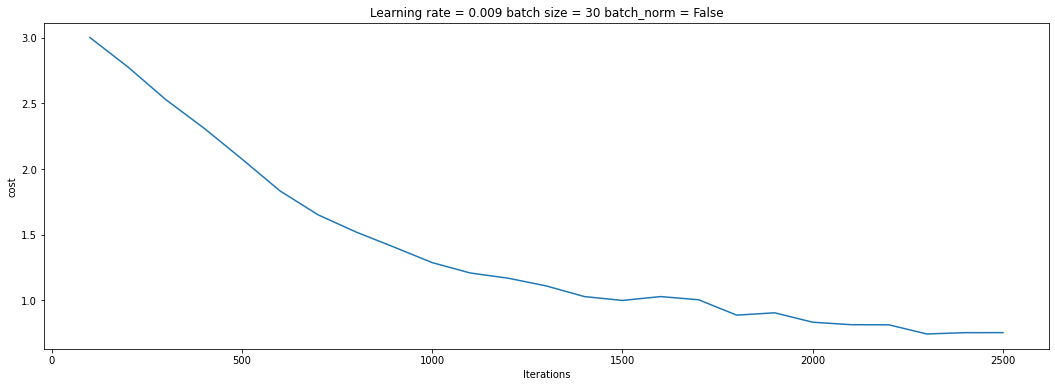

**************************************************
# iter 100 , val acc 33.300000000000004 , val cost 3.0000769952048376
# iter 200 , val acc 27.525 , val cost 2.9930346479249605
# iter 300 , val acc 25.39166666666667 , val cost 2.911286427695691
# iter 400 , val acc 27.800000000000004 , val cost 2.9216629100222975
# iter 500 , val acc 24.208333333333336 , val cost 2.9317410601910567
# iter 600 , val acc 22.791666666666664 , val cost 2.948590649399622
# iter 700 , val acc 22.525000000000002 , val cost 2.9489769799992356
reached stopping criteria in iteration: 700 , val cost : 2.9489769799992356
number of iterations:  7
batch size:  0.009
learning rate:  0.009
Accuarcy on train set:  22.43
Accuarcy on test set:  21.98
Training duration: 1.78 seconds


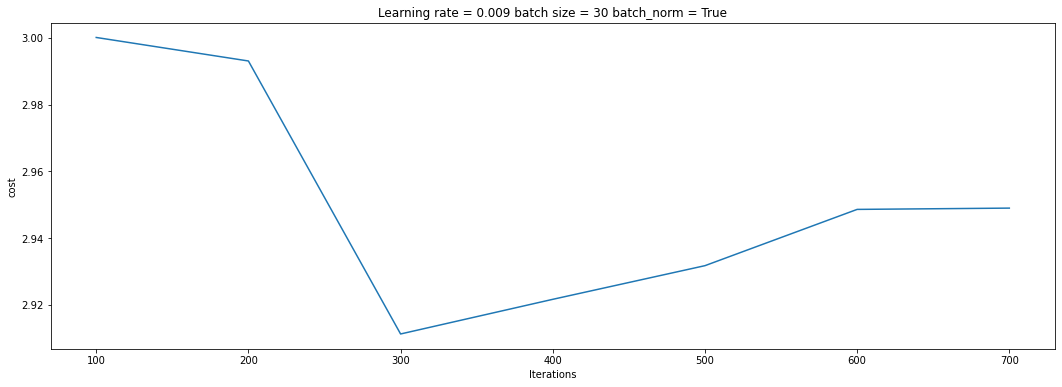

**************************************************


In [18]:
import random
import tensorflow as tf
from matplotlib import cm
from datetime import datetime
import matplotlib.pyplot as plt


def print_costs(costs , title, lr, batch_size, batch_norm):
    plt.figure(figsize=(18, 6))
    plt.plot([(i + 1) * 100 for i in range(len(costs))], costs)
    plt.ylabel('cost')
    plt.xlabel('Iterations')
    plt.title(f'Learning rate = {lr} batch size = {batch_size} batch_norm = {batch_norm}')
    plt.show()


def train_mnist(batch_size ,learning_rate , use_batchnorm):
    random.seed(123)

  
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    x_train = x_train.reshape(x_train.shape[0], 28 * 28)  # 784
    x_test = x_test.reshape(x_test.shape[0], 28 * 28)

    x_train = x_train.astype('float64')
    x_test = x_test.astype('float64')

    x_train = x_train / 255
    x_test = x_test / 255

    y_train = y_train.reshape(x_train.shape[0], 1)
    y_test = y_test.reshape(x_test.shape[0], 1)

    num_classes = 10
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    #plt.title((y_train[0]))
    #plt.imshow(x_train[0].reshape(28, 28), cmap=cm.binary)


    layers_dims = [784, 20, 7, 5, 10]

    st = datetime.now()

    parameters, costs = L_layer_model(x_train, y_train, layers_dims, learning_rate=learning_rate, num_iterations=50000, batch_size=batch_size,
                                          use_batchnorm=use_batchnorm)
    
    duration = (datetime.now()-st).total_seconds()


    # Compute accuracy
    accuarcy_train = Predict(x_train.T, y_train.T, parameters, use_batchnorm)
    accuarcy_test = Predict(x_test.T, y_test.T, parameters, use_batchnorm)
    

    print('number of iterations: ', len(costs)*100)
    print('batch size: ', learning_rate)
    print('learning rate: ', learning_rate)
    print('Accuarcy on train set: ', accuarcy_train)
    print('Accuarcy on test set: ', accuarcy_test)
    print(f'Training duration: {duration:.2f} seconds')
    
    return costs


if __name__ == "__main__":
  learning_rate = 0.009
  batch_size=100
  
  print("*" *50)
  print(f"LR = {learning_rate} batch_size = {batch_size}")
    
  costs = train_mnist(batch_size, learning_rate , use_batchnorm=False)
  print_costs(costs, 'no batch norm', lr=learning_rate, batch_size=batch_size, batch_norm =False)
  print("*" *50)

  costs = train_mnist(batch_size, learning_rate , use_batchnorm=True)
  print_costs(costs, 'with batch norm', lr=learning_rate, batch_size=batch_size, batch_norm =True)
  print("*" *50)

  learning_rate = 0.009
  batch_size=30
  
  print("*" *50)
  print(f"LR = {learning_rate} batch_size = {batch_size}") 
  costs = train_mnist(batch_size, learning_rate , use_batchnorm=False)
  print_costs(costs, 'no batch norm', lr=learning_rate, batch_size=batch_size, batch_norm =False)
  print("*" *50)

  costs = train_mnist(batch_size, learning_rate , use_batchnorm=True)
  print_costs(costs, 'with batch norm', lr=learning_rate, batch_size=batch_size, batch_norm =True)
  print("*" *50)
